In [1]:
!pip install -U scikit-learn==1.2.2 imbalanced-learn==0.10.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 5.0 MB/s eta 0:00:0000:01
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0


========================================
2. Imports
========================================

In [2]:

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms, models

import numpy as np
from collections import Counter
from imblearn.under_sampling import CondensedNearestNeighbour
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# ========================================
# 3. Device
# ========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [4]:
train_dir = "/kaggle/input/plants-dataset/CropsData/train"
test_dir  = "/kaggle/input/plants-dataset/CropsData/test"

In [5]:
# ========================================
# 5. Transforms & Dataset
# ========================================
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset  = datasets.ImageFolder(test_dir, transform=transform)

class_names = train_dataset.classes
print("Classes:", class_names)

Classes: ['American Bollworm on Cotton', 'Anthracnose on Cotton', 'Army worm', 'Becterial Blight in Rice', 'Brownspot', 'Common_Rust', 'Cotton Aphid', 'Flag Smut', 'Gray_Leaf_Spot', 'Healthy Maize', 'Healthy Wheat', 'Healthy cotton', 'Leaf Curl', 'Leaf smut', 'Mosaic sugarcane', 'RedRot sugarcane', 'RedRust sugarcane', 'Rice Blast', 'Sugarcane Healthy', 'Tungro', 'Wheat Brown leaf Rust', 'Wheat Stem fly', 'Wheat aphid', 'Wheat black rust', 'Wheat leaf blight', 'Wheat mite', 'Wheat powdery mildew', 'Wheat scab', 'Wheat___Yellow_Rust', 'Wilt', 'Yellow Rust Sugarcane', 'bacterial_blight in Cotton', 'bollworm on Cotton', 'cotton mealy bug', 'cotton whitefly', 'maize ear rot', 'maize fall armyworm', 'maize stem borer', 'pink bollworm in cotton', 'red cotton bug', 'thirps on  cotton']


In [6]:
# ========================================
# 6. Feature Extraction (MobileNetV2)
# ========================================
feature_extractor = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
feature_extractor.classifier = nn.Identity()  # remove classifier
feature_extractor = feature_extractor.to(device)
feature_extractor.eval()

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Extract train features
features, labels = [], []
with torch.no_grad():
    for imgs, lbls in train_loader:
        imgs = imgs.to(device)
        feats = feature_extractor(imgs)
        features.append(feats.cpu().numpy())
        labels.append(lbls.numpy())

X_train = np.vstack(features)
y_train = np.hstack(labels)

print("Train feature shape:", X_train.shape)
print("Original class distribution:", Counter(y_train))


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 111MB/s] 


Train feature shape: (15369, 1280)
Original class distribution: Counter({0: 375, 1: 375, 2: 375, 3: 375, 4: 375, 5: 375, 6: 375, 7: 375, 8: 375, 9: 375, 10: 375, 11: 375, 13: 375, 14: 375, 15: 375, 16: 375, 17: 375, 18: 375, 19: 375, 20: 375, 21: 375, 22: 375, 23: 375, 24: 375, 25: 375, 26: 375, 27: 375, 28: 375, 29: 375, 30: 375, 31: 375, 32: 375, 33: 375, 34: 375, 35: 375, 37: 375, 38: 375, 39: 375, 40: 375, 12: 374, 36: 370})


In [7]:
# ========================================
# 7. Apply Condensed Nearest Neighbour (CNN)
# ========================================
cnn = CondensedNearestNeighbour(random_state=42)
X_res, y_res = cnn.fit_resample(X_train, y_train)

print("After CNN class distribution:", Counter(y_res))

After CNN class distribution: Counter({36: 370, 37: 89, 22: 71, 21: 56, 25: 56, 35: 56, 2: 49, 26: 49, 33: 48, 0: 43, 24: 41, 27: 36, 10: 34, 20: 32, 23: 32, 40: 30, 7: 26, 13: 26, 34: 26, 1: 25, 14: 25, 39: 25, 15: 24, 32: 24, 17: 23, 38: 20, 29: 19, 30: 19, 6: 18, 8: 18, 3: 17, 5: 17, 18: 14, 4: 13, 28: 13, 11: 12, 12: 12, 16: 11, 31: 11, 9: 9, 19: 4})


In [8]:
# ========================================
# 8. Convert to TensorDataset
# ========================================
X_tensor = torch.tensor(X_res, dtype=torch.float32)
y_tensor = torch.tensor(y_res, dtype=torch.long)

train_resampled_dataset = TensorDataset(X_tensor, y_tensor)
train_resampled_loader  = DataLoader(train_resampled_dataset, batch_size=32, shuffle=True)

In [9]:
# ========================================
# 9. Build Classifier Model
# ========================================
class SimpleNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        return self.fc(x)

model = SimpleNN(X_train.shape[1], len(class_names)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
# ========================================
# 10. Training Loop (with Accuracy)
# ========================================
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    
    for X_batch, y_batch in train_resampled_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calculate accuracy
        _, preds = torch.max(outputs, 1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)
    
    epoch_loss = running_loss / len(train_resampled_loader)
    epoch_acc = correct / total
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")


Epoch [1/5], Loss: 3.0168, Accuracy: 0.2443
Epoch [2/5], Loss: 2.3835, Accuracy: 0.3357
Epoch [3/5], Loss: 1.9759, Accuracy: 0.4433
Epoch [4/5], Loss: 1.6506, Accuracy: 0.5172
Epoch [5/5], Loss: 1.4369, Accuracy: 0.5885


In [11]:
# ========================================
# 11. Extract Test Features
# ========================================
features_test, labels_test = [], []
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        feats = feature_extractor(imgs)
        features_test.append(feats.cpu().numpy())
        labels_test.append(lbls.numpy())

X_test = np.vstack(features_test)
y_test = np.hstack(labels_test)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)


In [12]:
# ========================================
# 12. Evaluate
# ========================================
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, preds = torch.max(outputs, 1)

y_pred = preds.cpu().numpy()

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average="macro"))
print("Recall:", recall_score(y_test, y_pred, average="macro"))
print("F1-score:", f1_score(y_test, y_pred, average="macro"))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=class_names))

Accuracy: 0.5478142076502732
Precision: 0.6431213179409859
Recall: 0.5478867033831628
F1-score: 0.5252183805775856

Classification Report:
                              precision    recall  f1-score   support

American Bollworm on Cotton       0.35      0.70      0.47       125
      Anthracnose on Cotton       0.45      0.66      0.53       125
                  Army worm       0.59      0.88      0.70       125
   Becterial Blight in Rice       0.54      0.37      0.44       125
                  Brownspot       0.75      0.61      0.67       125
                Common_Rust       0.91      0.55      0.69       125
               Cotton Aphid       0.76      0.49      0.60       125
                  Flag Smut       0.76      0.68      0.72       125
             Gray_Leaf_Spot       0.68      0.85      0.76       125
              Healthy Maize       1.00      0.28      0.44       125
              Healthy Wheat       0.59      0.30      0.39       125
             Healthy cotton    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:13

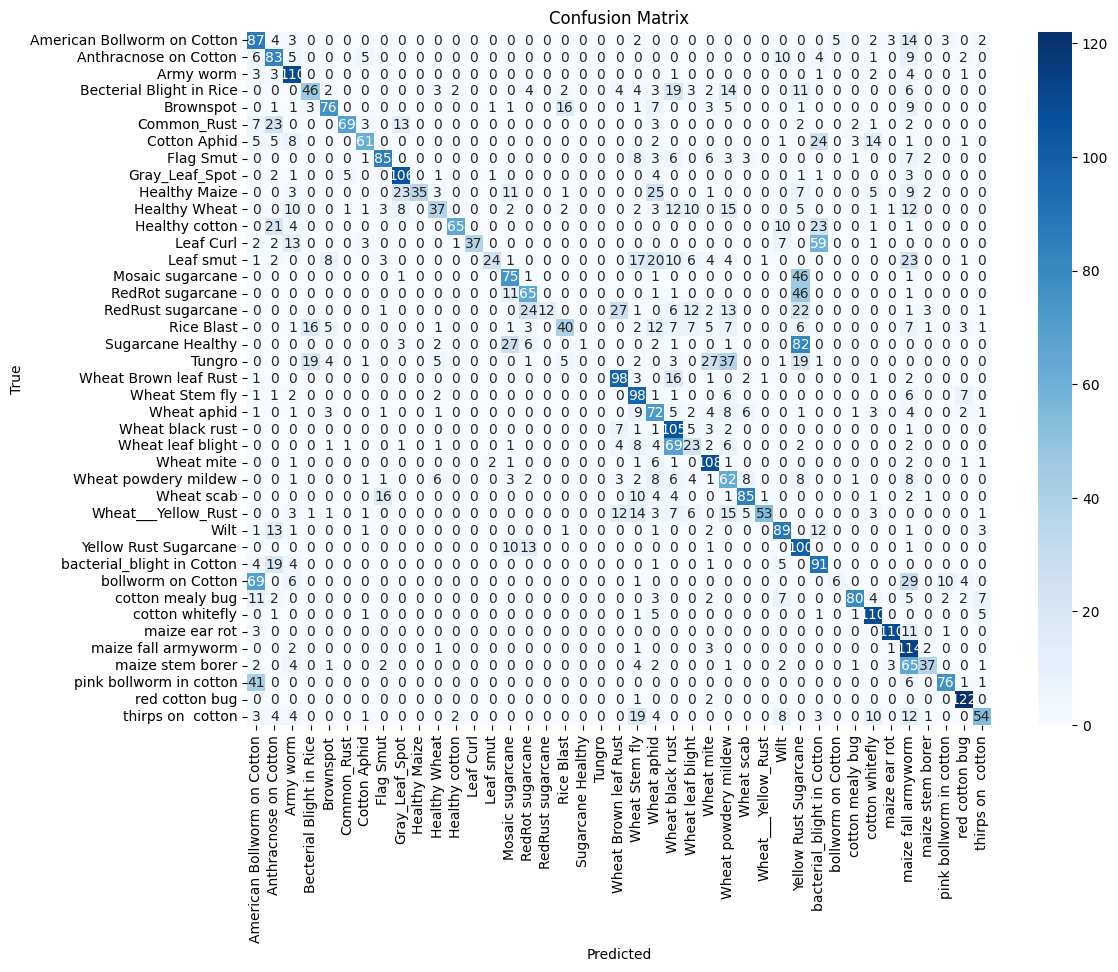

In [13]:

# ========================================
# 13. Confusion Matrix
# ========================================
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,9))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()